In [34]:
import sys
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn import metrics
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
# import torchvision.datasets as datasets
from util import datasets
import torchvision.utils as vutils

from util.pos_embed import interpolate_pos_embed
import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.22.2
1.4.1
1.10.2+cu113


### Purpose 目的
Identify the key features/dimensions that the model uses to make determinations in the classification task  

找出模型在分類任務中，用來做判定的關鍵特徵/維度

### How to find key features 如何找出關鍵特徵
- 將全世界的鳥類透過模型編碼(壓縮)成形狀為(1, dimension)的高維向量
    - 這個高維向量又稱為 embedding(representation, latent vector)
    - 在模型中以n=dimension組數值，編碼、描述鳥類的型態
    - 在ViT模型中， 圖塊嵌入(patch embedding)匯聚圖像資訊為類別表徵(cls embedding)，並使用cls embedding作為下游的分類任務使用 

- ~~借用<font color=lightgreen size=4> GradCam</font>概念，使用各類別(y)反向求導，求出對該類別有較大反應的導數所在維度(位於embedding的哪些維度上)~~
- Relevance Score * Gradients+" for each dimension is used as the basis for finding the key dimensions
    - [Transformer Interpretability Beyond Attention Visualization](https://github.com/hila-chefer/Transformer-Explainability) 
    - Relevance Score
        -  Tracing back the contributions of input nodes to the final prediction.
    - Gradients
        - class spesific
        - Only positive (+) values are used as a positive interpretation to reflect the category 
            - np.clip(grads, min=0)

 

- 關鍵特徵的決定採用投票方式
    - 採用iNatFT encoder的head(Linear layer)作為分類器(對應"種"層級的分類任務)
    - 使用GradeCam方法取得各個物種為單位的grad數值
    - 取得以"科"為單位的導數數值
        - 計算以科為單位的 mean/ medium    


In [19]:
# sys.path.remove('/home/AI_projects/yunghui/Transformer-Explainability')
sys.path

['/home/esslab/AI_projects/yunghui/Transformer-Explainability',
 '/home/esslab/AI_projects/yunghui/mae',
 '/home/esslab/anaconda3/envs/mae/lib/python39.zip',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9/lib-dynload',
 '',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/IPython/extensions',
 '/home/esslab/.ipython']

## Prepare Model and metadata

### Import "Transformer-Explainability" modules for get "Relevance score
- [CVPR 2021] [Official PyTorch implementation for Transformer Interpretability Beyond Attention Visualization, a novel method to visualize classifications by Transformer based networks.](https://arxiv.org/abs/2012.09838)


In [20]:
# adding Transformer-Explainability to the system path
sys.path.insert(0, '/home/esslab/AI_projects/yunghui/Transformer-Explainability')
 
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

### Load model

In [21]:
def load_encoder(ck, n_classes:int=1486, global_pool:bool=False, encoder_version:str='iNat_FT', **kwargs):
    # assert encoder_version == 'eBirdPT' or encoder_version =='iNatFT', f'Encoder_version must be either iNatFT or eBirdPT, got {encoder_version}'
    
    # model = models_vit.__dict__['vit_base_patch16'](num_classes=n_classes, global_pool=global_pool, )
    model = vit_LRP(num_classes=n_classes).cuda()
    
    checkpoint = torch.load(ck, map_location='cpu')
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    
    return model

In [22]:
encoder_version='eBirdFT' # 'iNatFT', 'eBirdFT' or 'eBirdPT',
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'
path_model = Path('output_dir')


print(f'Encoder  : {encoder_version}')

ck = path_model/'ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-149.pth'  #　eBird finetuned MAE

v_embedding = f'NP{norm_pixel}(Pretrain)_{encoder_version}{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_embedding}')


n_classes = 11186
print(f"Load pre-trained checkpoint from: {ck}")
model = load_encoder(ck, n_classes=n_classes, encoder_version=encoder_version)

 

Encoder  : eBirdFT
Embedding version : NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data)
Load pre-trained checkpoint from: output_dir/ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-149.pth
<All keys matched successfully>


### Load metadata 

In [23]:
%%time

data_path = '../../shared/eBird/download_ebird/downloaded'
val_data = 'jpg_top100'
meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.feather'
df_meta =  pd.read_feather(meta_data)


# Establish sp_id  

col_obj2cat = ['Format', 'Accessory', 'Asset_State', 'isInternalUser', 'mediaDownloadUrl', 'Playback', 'Microphone', 'Recorder', 'Taxon_Category', 
               'Age/Sex', 'Asset_Tags', 'Order', 'Behaviors', 'Country', 'Parent_Dir', 'Family', 'Background_Species', 'Genus', 'State', 'County']
for col in col_obj2cat :
    df_meta[col] =  df_meta[col].astype('category') 

col_label = ['Label'] 
col_basic = ['ML_Catalog_Number', 'Dir_FName']
col_file = ['Dir_FName', 'Parent_Dir', 'Sci_N']
col_taxon = ['Order', 'Family', 'Genus', 'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category']
col_geo = ['Country', 'Latitude', 'Longitude']
col_time = ['Year', 'Month', 'Day']
col_sel = col_label + col_basic + col_taxon + col_geo + col_time
df_meta = df_meta[col_sel].copy()

print(f'# of Order : {df_meta.Order.nunique()}')
print(f'# of Family : {df_meta.Family.nunique()}')
print(f'# of Genus: {df_meta.Genus.nunique()}')

print(df_meta.columns)

# of Order : 41
# of Family : 249
# of Genus: 2295
Index(['Label', 'ML_Catalog_Number', 'Dir_FName', 'Order', 'Family', 'Genus',
       'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category',
       'Country', 'Latitude', 'Longitude', 'Year', 'Month', 'Day'],
      dtype='object')
CPU times: user 6.13 s, sys: 4.99 s, total: 11.1 s
Wall time: 7.85 s


In [24]:
%%time

col_label = ['Label', 'Dir_class']
df_label_= pd.read_feather(meta_data)[col_label].drop_duplicates(subset=col_label) 
df_label_

CPU times: user 2.3 s, sys: 2.99 s, total: 5.29 s
Wall time: 2.06 s


,Label,Dir_class
0,3090,Acanthisitta_chloris
100,3091,Xenicus_gilviventris
200,3092,Acanthiza_apicalis
300,3093,Acanthiza_chrysorrhoa
400,3094,Acanthiza_cinerea
...,...,...
896502,9656,Zosterornis_hypogrammicus
896512,9657,Zosterornis_latistriatus
896515,9658,Zosterornis_nigrorum
896519,9659,Zosterornis_striatus


In [25]:
CLS2IDX_ = (df_label_.sort_values(by=['Label']).dropna(subset=['Dir_class']))
CLS2IDX = {l_: cls_ for l_, cls_ in zip(CLS2IDX_.Label.values, CLS2IDX_.Dir_class.values)}
print(len(CLS2IDX))
IDX2CLS = {cls_: l_  for l_, cls_ in zip(CLS2IDX_.Label.values, CLS2IDX_.Dir_class.values)}

11186


#### Load Embedding

In [72]:
%%time
file_ = f'embeddings_{v_embedding}.npz'
print(f'{file_}')
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)


embeddings_NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data).npz
(896555, 768)
CPU times: user 14.6 s, sys: 887 ms, total: 15.5 s
Wall time: 15.5 s


## Get LPR * grad from last layer

In [27]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

mean, std = IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# simple augmentation
transform = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean, std)])

In [28]:
image = Image.open('temp/seabird_2.jpg').convert('RGB') 
image_ = transform(image)
inputs = image_.unsqueeze(0).cuda()

#### def get_LPR_score_head()

In [29]:

def get_LPR_score_head(inputs_, model, index=None, 
                       method="transformer_attribution", is_ablation=False, start_layer=0, **kwargs) ->torch.tensor: 

    kwargs = {"alpha": 1}
    output = model(inputs_)
    if index is None : 
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot_sum = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot_sum.backward(retain_graph=True)

    rel_score  = model.head.relprop(torch.tensor(one_hot_vector).to(inputs_.device), **kwargs) # shape : (batch, dim). dim=768

    return rel_score

In [30]:
rel_score_  = get_LPR_score_head(inputs, model, index=None)
print(rel_score_.shape)

torch.Size([1, 768])


In [154]:
rel_score_ = model.head.relprop(torch.tensor(one_hot_vector).to(input.device), **kwargs) # shape : (batch, dim). dim=768
print(rel_score_.shape)

torch.Size([1, 768])


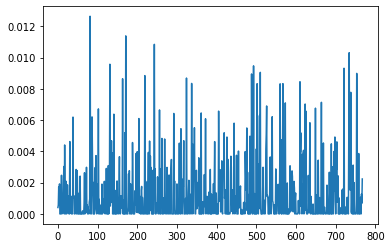

In [112]:
plt.plot(rel_score_head.reshape(-1).cpu().data.numpy())

#### def get_grad_head()

In [31]:
def get_grad_head(inputs_, model, index=None, **kwargs)->torch.tensor:
    embedding_ = model.forward_features(inputs_) # shape:(n_batch, dim). 
    features_ =  embedding_.clone().detach().to(inputs_.device).requires_grad_(True)
    pred = model.head(features_)  # (n_batch, n_classe)

    # Whether to use the ground truth label, or predicted by model
    if index is None :               
        index = np.argmax(pred.detach().cpu().numpy(), axis=1)  # return (n_batch, n_classes)

    # one_hot encoding labels 
    one_hot = F.one_hot(torch.tensor(index).clone().detach() , num_classes=n_classes).to(inputs_.device) # (n_batch, n_classe)
    pred.backward(one_hot)                             

    # grads of embeddings. shape:(n_batch, dim). 
    inputs_grad_ = features_.grad.clone().detach()
    return inputs_grad_

In [14]:
grad_ = get_grad_head(image_.unsqueeze(0).cuda(), model)
grad_.shape

torch.Size([1, 768])

In [32]:
# filter label > 0
mask_label_positive = df_meta.Label >= 0

data_path = '../../shared/eBird/download_ebird/downloaded'
val_data = 'jpg_top100'
meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.feather'
files_path_  = list(data_path + '/' +  val_data + '/' + df_meta[mask_label_positive].Dir_FName	+ '.jpg')
labels = df_meta[mask_label_positive].Label.values
print(f'Original data size : {len(df_meta):,d}  After filter "label > 0" : {len(files_path_):,d}')
assert len(files_path_) == len(labels)
assert  df_meta.Label.dtype == 'int64'

Original data size : 896,555  After filter "label > 0" : 896,195


In [35]:

batch_size = 100
dataset = datasets.ImageDatasetFromFile(files_path_, labels, transform=transform)
print(len(dataset))

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, pin_memory=True, drop_last=False, shuffle=False,
        num_workers=10,  batch_size=batch_size,)
print(len(data_loader))

896195
8962


### Get LPR * grad for all data

In [14]:
# %%time

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# start_time = time.time()
# for i, (imgs, labels)  in enumerate(data_loader):

#     imgs = imgs.to(device, non_blocking=True)
#     rel_score_  = get_LPR_score_head(imgs, model, index=labels.numpy())
#     grad_ = get_grad_head(imgs, model, index=labels.numpy())
#     rel_grad_ = (torch.clip( grad_, min=0)*rel_score_).cpu().data.numpy()

#     rel_grads = rel_grad_ if i == 0 else np.concatenate((rel_grads, rel_grad_), axis=0) 
    
#     passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
#     info = f'Progress:{i+1:4d}, {100*(i+1)/len(data_loader):3.2f}%. ' 
#     info += f'| Feature_shape: {rel_grads.shape}.' 
#     info += f'| Time: {passing_time}. '
#     print(info, end='\r')
#     # if i>10 :break


CPU times: user 3h 24min 23s, sys: 1h 54min 46s, total: 5h 19min 10s47. 
Wall time: 3h 40min 47s


In [37]:
%%time
file_ = f'rel_grads_{v_embedding}.npz'
print(f'{file_}')
# np.savez_compressed(path_embeddings/file_, rel_grads=rel_grads)
# print(f'{file_} saved')
# np.save(path_embeddings.joinpath(file_) , embeddings)
rel_grads = np.load(path_embeddings/file_)['rel_grads']
print(rel_grads.shape)


rel_grads_NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data).npz
(896195, 768)
CPU times: user 11.4 s, sys: 543 ms, total: 12 s
Wall time: 12 s


In [83]:
pd.DataFrame(rel_grads.reshape(-1)).describe()

,0
count,6.882778e+08
mean,1.306675e-04
std,4.420232e-04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,4.659505e-05
max,6.441317e-02


CPU times: user 6.81 s, sys: 343 µs, total: 6.81 s
Wall time: 6.81 s


(array([6.71848334e+08, 1.19329630e+07, 2.91788000e+06, 9.44210000e+05,
        3.55650000e+05, 1.47951000e+05, 6.62170000e+04, 3.11050000e+04,
        1.53850000e+04, 7.98800000e+03, 4.31400000e+03, 2.39500000e+03,
        1.37000000e+03, 7.72000000e+02, 4.63000000e+02, 2.99000000e+02,
        1.66000000e+02, 1.11000000e+02, 6.90000000e+01, 4.80000000e+01,
        2.10000000e+01, 1.30000000e+01, 8.00000000e+00, 6.00000000e+00,
        5.00000000e+00, 5.00000000e+00, 2.00000000e+00, 4.00000000e+00,
        2.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]),
 array([0.        , 0.00128826, 0.00257653, 0.00386479, 0.00515305,
        0.00644132, 0.0077

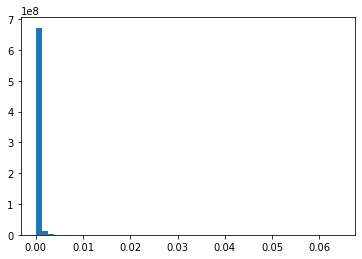

In [95]:
%%time
plt.hist(rel_grads.reshape(-1) ,bins=50);

CPU times: user 49.1 s, sys: 877 ms, total: 50 s
Wall time: 50 s


''

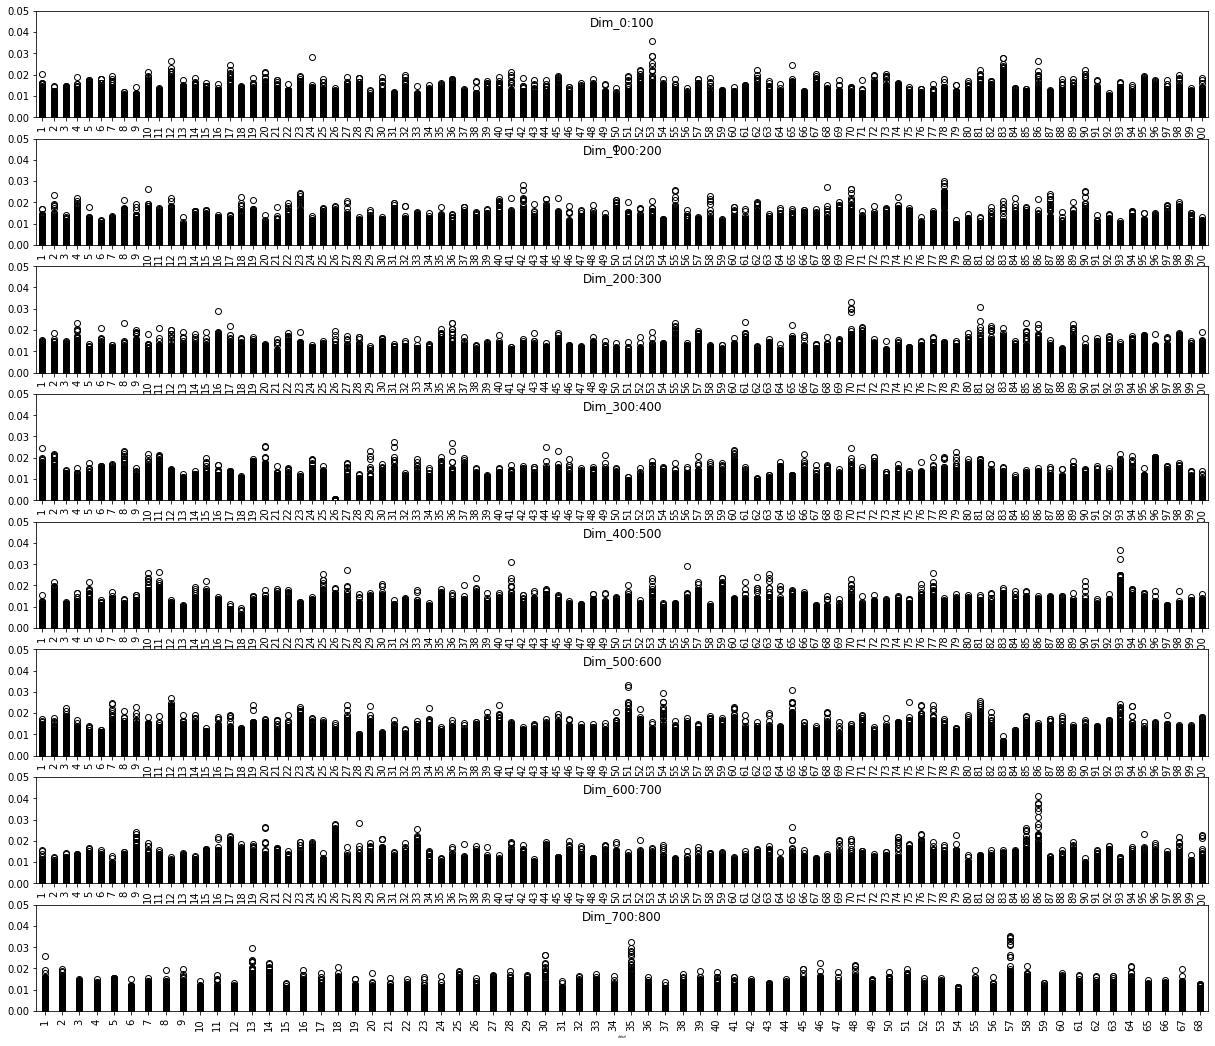

In [92]:
%%time
interval = 100
n, d = rel_grads.shape
start=0
row=int(np.ceil(d/interval))
h = row*2.3
fig, axs = plt.subplots(row,figsize=(21,h))
for r in range(row):
    slice_ = rel_grads[:, start : start+interval]
    axs[r].boxplot(slice_)
    axs[r].set_title(f'Dim_{start}:{start+interval}', y=0.8)
    axs[r].tick_params(axis='x', labelrotation=90)
    axs[r].set_xlabel('xlabel', fontsize=3)
    axs[r].set_ylim([0, 0.05])
    start += interval
;

CPU times: user 3min 39s, sys: 1min 36s, total: 5min 15s
Wall time: 23.2 s


<timed exec>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


''

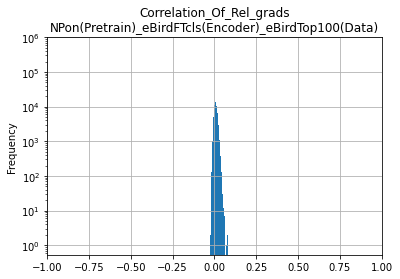

In [93]:
%%time
title = f'Correlation_Of_Rel_grads\n{v_embedding}'

corr_matrix = np.corrcoef(np.transpose(rel_grads))
# mask =  np.triu(np.ones_like(corr_matrix, dtype=bool))

xlim=(-1,1)
ylim=(0,1e6)
figsize = (6,4)

fig, ax = plt.subplots(figsize = figsize )
ax.hist(np.tril(corr_matrix ,k=-1).reshape(-1,1), bins=100)

ax.grid(True)
ax.set_yscale('log')
ax.set(title=title,  ylabel='Frequency',  xlim=xlim, ylim=ylim)
;

# Determine key features by voting on 'Family' level
根據分類層級(科)投票決定關鍵特徵

### Mean of Concern Degree about Features on species/genus
- 找出每科的 top N 個重要分類特徵 (i.e. 對分科有最大影響力的 top N 維度)，並將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。我們視低維度的關鍵特徵為同時具有分辨力 (recognition) 與代表性 (representation) 的蛾標本影像特徵，並用於後續的分析與視覺化的解釋。
- 我們借用 Grad-CAM 的概念以找出分科的重要外觀特徵，透過反向傳播演算法 (back propagation) 求出分科模型中對應於每個輸入值的 gradient vector，是為特徵關注度向量。我們在此計算每個物種的平均特徵關注度，並以 voting 的方式，決定每個科的重要特徵。
- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。 

#### family_list, fam2digit

In [38]:
# filter label > 0
mask_label_positive = df_meta.Label >= 0

family_list = list(df_meta.Family.dropna().unique())
family_list.sort()
print(len(family_list))

fam2digit = dict(zip(family_list, range(len(family_list))))
fam2digit.items()

labels = df_meta[mask_label_positive].Family.map(fam2digit).values  # 科名編碼
print(f'labels  : {labels.shape}')

n_classes = len(fam2digit)
print(f'n_classes  : {n_classes}')

249
labels  : (896195,)
n_classes  : 249


- 建立:科-物種"索引

In [39]:
metric = 'Median' # 'Mean', 'Median'

In [40]:

def pool_grads(grads, taxon_list:list=None, metric:str='Mean', df:pd.DataFrame=None ):
    
    for i, cls_ in enumerate(taxon_list):
        index  = df.query(f"{taxon_unit} == @cls_").index.values
            
        if metric == 'Median':
            grads_pool_ = np.median(grads[index], axis=0).reshape(1,-1)
        elif  metric == 'Mean':
            grad_pool_ = np.mean(grads[index], axis=0).reshape(1,-1)

        grads_pool = grads_pool_ if i == 0 else  np.concatenate([grads_pool_, grads_pool])
    
        print(f'{i:4,d}. shape : {grads_pool.shape} |  {taxon_unit} - {cls_} ', end='\r')
    return grads_pool
    

- Species

In [41]:
%%time

taxon_unit = 'Label' # Species
taxon_list = np.sort(df_meta[mask_label_positive][taxon_unit].dropna().unique())
df_ = df_meta[mask_label_positive].reset_index()  

# grads_sp_mean = pool_grads(grads, taxon_list , metric, df=df_ )
grads_sp_mean = pool_grads(rel_grads, taxon_list , metric, df=df_ )
print('\n', grads_sp_mean.shape)

11,185. shape : (11186, 768) |  Label - 11185 
 (11186, 768)
CPU times: user 1min 19s, sys: 4.42 s, total: 1min 24s
Wall time: 1min 21s


- Genus

In [42]:
%%time
taxon_unit = 'Genus'
taxon_list = np.sort(df_meta[mask_label_positive][taxon_unit].dropna().unique())
df_ = df_meta[mask_label_positive].reset_index()  

grads_genus_mean = pool_grads(rel_grads, taxon_list , metric, df=df_ )
print('\n', grads_genus_mean.shape)

2,294. shape : (2295, 768) |  Genus - Zosterornis is   s 
 (2295, 768)
CPU times: user 26.7 s, sys: 229 ms, total: 26.9 s
Wall time: 26.5 s


### 找出關鍵特徵數量(N-union)
- 以最小但又具足夠鑑別度的 N 與 N-union 來描述與代表科的特徵。我們窮舉 N = 1 ~ n_topk 這個範圍中對應的 N-union 個關鍵特徵。
- 基於每個物種在關鍵特徵空間中的 embedding，依科計算分群的三個指標 (Silhouette Coefficient, Calinski and Harabasz score, 與 Davies-Bouldin score)
    - 標準化並加總評估後得到當 N=-, N-union=- 時有最佳的科分群結果，約為總特徵數的 - % (-/768)。

#### Convert the "Degree of Concern about Features" to "Key Features" on mean of species 

- 物種均值的特徵關注度(top_n)
    - 在物種層級指定top_n個重要維度
    - 蒐集對應top_n特徵對應的特徵位置指標
    - 依據top_n位置將關注度值轉為one_hot編碼(1 or 0)
    - 得到以物種均值為單位的one hot編碼格式的特徵關注度數值(即每個物種1票)
- 儲存 對應的 top_n: index_N of Spesies

In [43]:
def one_hot_topk(inputs:np.array, n_topk:int)->np.array:
    '''
    encoding inputs(n, dim) to one_hot format(0 or 1) 
    threshod depends on quantile of topk for each sample
    encoding : x = 1 if x > q_topk else 0
    '''
    assert len(inputs.shape)==2
    n, dim = inputs.shape

    # calculate quantile of topk for each sample. 
    q_topk = np.quantile(inputs, q=(dim-n_topk)/dim, axis=1)   # shape : (n,)
    # broadcast quantile_topk from (n,) to (n, dim)
    q_topk = np.repeat(q_topk.reshape(n,-1), dim, axis=1)     
    # encoding : x = 1 if x > q_topk else 0
    
    inputs_one_hot_topk = np.where(inputs >= q_topk, 1, 0)

    
    return inputs_one_hot_topk


In [86]:
# taxon_unit = 'Genus' # 'Species' or 'Genus'
taxon_unit = 'Genus'


In [87]:

# taxon_unit = 'Genus' # 'Species' or 'Genus'
if taxon_unit == 'Genus':
    grads_mean = grads_genus_mean
elif taxon_unit == 'Species':
    grads_mean = grads_sp_mean

print(grads_mean.shape)

(2295, 768)


In [88]:
%%time

n_topk = 5
grads_oh_topk = one_hot_topk(grads_mean, n_topk)
print(grads_oh_topk.shape)

# assert each sum of each dimension per data is equal to n_topk
assert (np.sum(grads_oh_topk, axis=1) == n_topk).all(), f'Sum in dim {np.where(np.sum(grads_oh_topk, axis=1) != n_topk)[0]}  \
is not equal to n_topk' 
# assert sorted index of each dimension per data is of "inputs" is same as "inputs_one_hot_topk"
assert (np.sort(np.argsort(grads_mean,)[:, -1 -(n_topk-1): ])  ==  
    np.sort(np.argsort(grads_oh_topk)[:, -1 -(n_topk-1): ])).all()

(2295, 768)
CPU times: user 152 ms, sys: 693 µs, total: 153 ms
Wall time: 153 ms




####  Combine the key features of all families to obtain N-union key features
算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。
- 根據"科-物種"索引各科下各物種的top_n個重要維度
- 將各物種的top_n個重要維度透投票加總(one_hot編碼後每個物種/屬1票)
- 取得以科為單位的N-union重要維度
- ~~one_hot 編碼 科為單位的N-union重要維度~~
    - 排序各科前top_n重要維度(將投票數voting轉換為排序)
    - x = 1 if x > 0 else 0
- 儲存 對應的 top_n: index_N_union of Family
    

##### Voting on Family level

In [89]:
if taxon_unit == 'Genus':
    family_index = (df_meta[mask_label_positive].groupby(['Family', 'Genus']).count().query('ML_Catalog_Number>0').reset_index()[['Family', 'Genus']]) 
elif taxon_unit == 'Species':
    family_index = (df_meta[mask_label_positive].groupby(['Family', 'Label']).count().query('ML_Catalog_Number>0').reset_index()[['Family', 'Label']]) 
# elif taxon_unit == 'Species':
    # family_index = (df_meta.groupby(['family', 'Sci_Name']).count().reset_index()[['family', 'Sci_Name']])
family_index

,Family,Genus
0,Acanthisittidae,Acanthisitta
1,Acanthisittidae,Xenicus
2,Acanthizidae,Acanthiza
3,Acanthizidae,Acanthornis
4,Acanthizidae,Aphelocephala
...,...,...
2290,Zosteropidae,Sterrhoptilus
2291,Zosteropidae,Tephrozosterops
2292,Zosteropidae,Yuhina
2293,Zosteropidae,Zosterops


In [90]:
%%time
# Voting on Family level to get the key features of all families  
# n, dim = grads_mean_topk.shape
def get_voting_family(grads_oh_topk:np.ndarray=None): 
    for i, family_ in enumerate(family_index.Family.unique()):
        index_fm = family_index.query("Family == @family_").index.values
        voting_family_ = np.sum(grads_oh_topk[index_fm], axis=0, keepdims=True)  # (1, dim)
        # assert voting_family_.size ==  dim      # dim 

        voting_family = voting_family_ if i==0 else np.concatenate([voting_family_, voting_family])

        print(f'{i:3,d}. shape : {voting_family.shape} | Family : {family_:20s} ', end='\r')
    return voting_family

voting_family = get_voting_family(grads_oh_topk)
print('\n', voting_family.shape)
voting_family 

248. shape : (249, 768) | Family : Zosteropidae         
 (249, 768)
CPU times: user 272 ms, sys: 10.8 ms, total: 283 ms
Wall time: 269 ms


array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

- Calculate the n_topk positions with the highest total votes in each Family  
算出每個科當中總得票最高的N個位置

In [91]:
index_ = np.argsort(voting_family, axis=1)[:, -n_topk:]
print(index_.shape)

(249, 5)


In [92]:
voting_Fmy_oh_topk = one_hot_topk(voting_family, n_topk)

# assert each sum of each dimension per data is equal to n_topk
assert (np.sum(voting_Fmy_oh_topk, axis=1) == n_topk).all(), f'Sum in dim : {np.where(np.sum(voting_Fmy_oh_topk, axis=1) != n_topk)[0]}  \
is not equal to n_topk' 
# assert sorted index of each dimension per data is of "inputs" is same as "inputs_one_hot_topk"
assert (np.sort(np.argsort(voting_family,)[:, -1 -(n_topk-1): ])  ==  
    np.sort(np.argsort(voting_Fmy_oh_topk)[:, -1 -(n_topk-1): ])).all()

AssertionError: Sum in dim : [  0   2   3   4   7   8   9  11  12  13  15  16  17  19  20  21  22  24
  25  26  28  29  31  34  37  39  40  43  46  47  50  51  52  53  54  55
  56  57  58  59  61  62  65  67  68  69  73  74  77  78  79  82  83  84
  85  86  88  90  91  94  95  96  97  99 100 103 104 105 107 108 110 111
 113 118 119 120 121 122 123 126 127 128 129 130 132 134 136 137 138 139
 140 142 143 145 146 147 148 150 153 159 161 163 164 165 167 168 169 171
 175 178 184 186 188 189 190 191 192 193 194 195 196 198 200 202 205 207
 208 209 210 211 212 213 214 216 217 218 219 220 223 224 225 227 230 231
 237 238 239 240 241 244 245 246 247 248]  is not equal to n_topk

#### Get the combination of topk - N_union

In [93]:
%%time
topks = range(1 ,51)

n, dim = rel_grads.shape
print(n, dim)


if taxon_unit == 'Genus':
    grads_mean = grads_genus_mean
elif taxon_unit == 'Species':
    grads_mean = grads_sp_mean

print(grads_mean.shape)

# filter positive grads
# grads_mean_pos = np.clip(grads_mean , 0, None) # transform negative grads to 0

index_n_unions = []
for i, topk_ in enumerate(topks) :
    
    # transform grads to voting value on sp or genus level, sort by values
    grads_oh_topk = one_hot_topk(grads_mean, topk_)  
    # voting result at Family level
    voting_family = get_voting_family(grads_oh_topk)  
    # transform voting result according topk
    voting_Fmy_oh_topk = one_hot_topk(voting_family, topk_) 
    # sum the voting results on eaeh diemnsion
    features_topk_families_voting = np.sum(voting_Fmy_oh_topk ,axis=0)  
    
    # get union of voting result
    index_ = np.where(features_topk_families_voting > 0)[0]         # get union from all dimension which voting greater than 0                 
    index_n_union_ = np.where(index_ > dim, index_ - dim, index_)   # unstack dimensions from 'dim + dim' to dim  
    index_n_union_ = np.unique(index_n_union_)                      # remove duplicated dimensions
    
    index_n_unions.append(index_n_union_)
    print(i, topk_, end='\r')
index_n_unions = np.asanyarray(index_n_unions)

896195 768
(2295, 768)
CPU times: user 15.5 s, sys: 605 ms, total: 16.1 s      
Wall time: 15.5 s


<timed exec>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [94]:

file_ = f'index_n_unions_rel_grads_{taxon_unit}.npy'
np.save(path_embeddings/file_, index_n_unions)
index_n_unions = np.load(path_embeddings/file_ , allow_pickle=True)


In [ ]:
index_n_unions

<AxesSubplot:title={'center':'Combination of topk - N_union_Genus'}, xlabel='topk', ylabel='n_unions'>

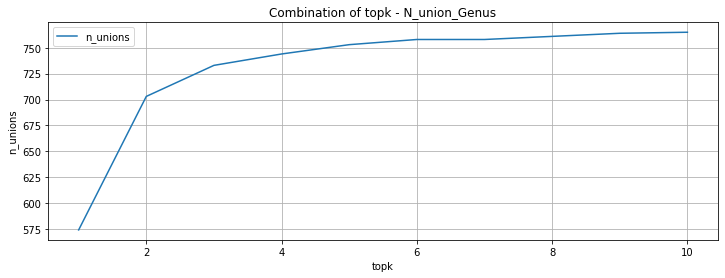

In [95]:
n_unions_  = [len(idxs_) for idxs_ in index_n_unions]
title = f"Combination of topk - N_union_{taxon_unit}"
figsize = (12,4)

df_Nuniun = pd.DataFrame(n_unions_, index=range(1, len(n_unions_)+1), columns=['n_unions'] )
(df_Nuniun[:10].plot(xlabel="topk", ylabel="n_unions", 
                     grid=True, title=title, figsize=figsize )
)

In [96]:
df_Nuniun = pd.DataFrame(n_unions_, index=range(1, len(n_unions_)+1), columns=['n_unions'] )
df_Nuniun[:10] 


,n_unions
1,574
2,703
3,733
4,744
5,753
6,758
7,758
8,761
9,764
10,765


#### NOTE
-  tok=1 時，	n_unions才小於100
    -   tok=1, n_unions=74 (9.63%)

---

### Clustering performance evaluation

In [97]:
def get_Nunion_features (features=None, n=None, index_n_unions=index_n_unions):
    index = index_n_unions[n]
    _, dim = features.shape
    mask = ~np.isin(np.arange(dim), index)  # Filtering out non-critical dimensions by reverse selection   
    index_inverse = np.arange(dim)[mask]
    
    features_ = features.copy()             #  Recopy features_ every time, otherwise the original data will be overwritten
    features_[:, index_inverse] = 0         # Freeze the value of the dimension that is not selected to 0
    return features_

In [98]:
n_range = np.arange(10)

In [99]:
%%time
# larger is better. The score is higher when clusters are dense and well separated
ch_scores = []
for n in n_range:
    features_ = get_Nunion_features (features=embeddings[mask_label_positive], n=n, index_n_unions=index_n_unions)
    score = metrics.calinski_harabasz_score(features_, df_meta[mask_label_positive].Family)
    ch_scores.append(score) 
    print(f'topk : {n}, score : {score:.3f}', end='\r')

CPU times: user 50.1 s, sys: 36.1 s, total: 1min 26s
Wall time: 1min 28s


In [100]:
%%time
# Closer Zero is better. Zero is the lowest possible score. Values closer to zero indicate a better partition.
db_scores = []
for n in n_range:
    features_ = get_Nunion_features (features=embeddings[mask_label_positive], n=n, index_n_unions=index_n_unions)
    score = metrics.davies_bouldin_score(features_, df_meta[mask_label_positive].Family)
    db_scores.append(score) 
    print(f'topk : {n}, score : {score:.3f}', end='\r')

CPU times: user 21min 6s, sys: 51min 35s, total: 1h 12min 41s
Wall time: 1min 49s


In [ ]:
%%time
# larger is better. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters
 
sil_scores = []
for n in n_range:
    features_ = get_Nunion_features (features=embeddings[mask_label_positive], n=n, index_n_unions=index_n_unions)
    score = metrics.silhouette_score(features_, df_meta[mask_label_positive].Family)
    sil_scores += score
    print(f'topk : {n}, score : {score:.3f}', end='\r')

In [103]:
data = [ch_scores, db_scores, 
        sil_scores
       ]
metric_score = (pd.DataFrame(np.array(data).T,
                             index=n_range,
                             columns=["calinski_harabasz", "davies_bouldin", 
                                      "Silhouette"
                                     ])
                # .reset_index().rename(columns={'index':'topk'})
               )
# metric_score.topk = metric_score.topk + 1
metric_score.index = df_Nuniun.n_unions[:len(n_range)].values

file_ = f'clustering_metric_score_features_rel_grads_{taxon_unit}.csv'
# metric_score.to_csv(f'meta/{file_}')
metric_score = pd.read_csv(f'meta/{file_}', header=[0], index_col=0)
metric_score[:5]

/tmp/ipykernel_2106279/2835604320.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  metric_score = (pd.DataFrame(np.array(data).T,


ValueError: Shape of passed values is (3, 1), indices imply (10, 3)

best topk : 1, N_uniun 406
Clustering Eval Score : 1.700


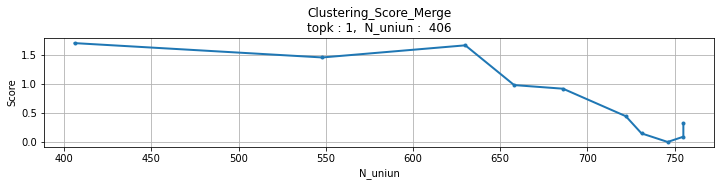

In [84]:
 #　將三個metric標準化處理，取值在0~1。
metric_score.davies_bouldin = metric_score.davies_bouldin*-1  # davies_bouldin為越小越佳，因此先乘上負號
metric_score_ = (metric_score -  metric_score.min()) / (metric_score.max() -  metric_score.min())
# idx = pd.IndexSlice
# metric_score_.loc[:, idx[:, "2D"]].sum(axis=1)
# metric_score_.loc[:, idx[:, "3D"]].sum(axis=1)
metric_score_merge = metric_score_.sum(axis=1)
best_topk =  metric_score_merge.argmax() + 1
print(f"best topk : {best_topk}, N_uniun {metric_score_merge.idxmax()}")  # 檢視分群最佳結果的 N_union
print(f"Clustering Eval Score : {metric_score_merge.max():.3f}")

figsize=(12, 2); marker="."; lw = 2
title = "Clustering_Score_Merge"
title += f"\ntopk : {best_topk},  N_uniun :  {metric_score_merge.idxmax()}"
metric_score_merge.plot(title=title , grid=True, figsize=figsize, lw=lw, marker=marker, xlabel='N_uniun', ylabel='Score');         # 三個指標標準化後加總

# metric_score.silhouette.plot(title="Silhouette_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

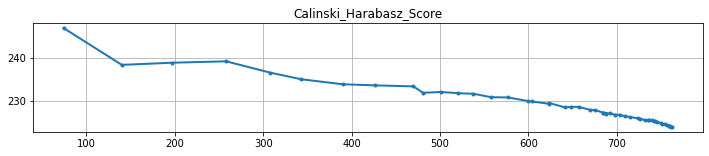

In [281]:
# The score is higher when clusters are dense and well separated
metric_score.calinski_harabasz.plot(title="Calinski_Harabasz_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

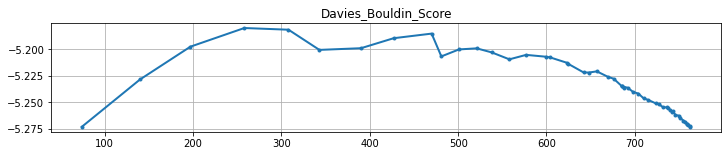

In [275]:
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
metric_score.davies_bouldin.plot(title="Davies_Bouldin_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

##### Note about Clustering performance evaluation:
- topk=4，N-union=258時，有最佳的科分群分數(1.66)，約為總特徵數的 33.59% (258/768)
- 分群評估方法中，由於silhouette_score太過費時，因此本次未納入
- 作圖檢視，clustering結果與metric_score分數一致，並不是使用越多特徵、分群效果就越明顯 

# Understanding the visual significance of key features